In [30]:
import torch
import torch.nn.functional as F
from torch import nn
import numpy as np
from torch.nn import Parameter
import torch.optim as optim
import random
import matplotlib.pyplot as plt

def split_cols(mat, lengths):
    assert mat.size()[1] == sum(lengths), "Lengths must be summed to num columns"
    l = np.cumsum([0] + lengths)
    results = []
    for s, e in zip(l[:-1], l[1:]):
        results += [mat[:, s:e]]
    return results

In [2]:
# Memory for NTM's
class NTMMemory(nn.Module):
    def __init__(self,N,M):
        super(NTMMemory,self).__init__()
        self.N = N
        self.M = M
        self.register_buffer('mem_bias', torch.Tensor(N, M))
        std = 1 / (np.sqrt(N + M))
        nn.init.uniform_(self.mem_bias, -std, std)
    
    def reset(self,bs):
        self.bs = bs
        self.memory = self.mem_bias.clone().repeat(bs,1,1)
    
    def size(self):
        return self.N , self.M
    
    def read(self,weights):
        return torch.matmul(weights.unsqueeze(1),self.memory).squeeze(1)
    
    def write(self,w,e,a):
        self.prev_mem = self.memory
        self.memory = torch.Tensor(self.bs, self.N, self.M)
        erase = torch.matmul(w.unsqueeze(-1),e.unsqueeze(1))
        add = torch.matmul(w.unsqueeze(-1),a.unsqueeze(1))
        self.memory = self.prev_mem*(1-erase) + add
    
    def address(self,key_vector,beta,g,shift_weight,gamma,w_prev):
        content_w = self.cosine_similarity(key_vector,beta)
        
        gated_w = self.interpolate(w_prev,content_w,g)
        w = self.conv_shift(gated_w,shift_weight)
        w = self.sharpen(w,gamma)
        return w
    
    def cosine_similarity(self,key_vector,beta):
        key_vector = key_vector.view(self.bs,1,-1)
        w = F.softmax(beta*F.cosine_similarity(self.memory + 1e-16, key_vector + 1e-16 , dim=-1),dim=-1)
        return w
    
    def interpolate(self,w_prev,content_w,g):
        return g*content_w + (1-g)*w_prev
    
    def conv_shift(self,gated_w,shift_weight):
        res = torch.zeros(gated_w.size())
        for b in range(self.bs):
            res[b]= convolve(gated_w[b],shift_weight[b])
        return res
    
    def sharpen(self,w,gamma):
        w = w**gamma
        w = torch.div(w,torch.sum(w,dim=1).view(-1,1)+1e-16)
        return w
        
def convolve(w, s):
    assert s.size(0) == 3
    t = torch.cat([w[-1:], w, w[:1]])
    c = F.conv1d(t.view(1, 1, -1), s.view(1, 1, -1)).view(-1)
    return c

In [3]:
# NTM controller using LSTM's
class LSTMController(nn.Module):
    def __init__(self,n_inputs,n_outputs,n_layers):
        super(LSTMController,self).__init__()
        
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(n_inputs,n_outputs,n_layers)
        self.lstm_hidden_bias = Parameter(torch.randn(self.n_layers, 1, self.n_outputs) * 0.05)
        self.lstm_cellstate_bias = Parameter(torch.randn(self.n_layers, 1, self.n_outputs) * 0.05)
        
        self.reset_params()
    
    def create_new_state(self,bs):
        hidden_state = self.lstm_hidden_bias.clone().repeat(1,bs,1)
        cell_state = self.lstm_cellstate_bias.clone().repeat(1,bs,1)
        return hidden_state , cell_state
    
    def reset_params(self):
        for p in self.lstm.parameters():
            if p.dim() == 1:
                nn.init.constant_(p, 0)
            else:
                stdev = 5 / (np.sqrt(self.n_inputs +  self.n_outputs))
                nn.init.uniform_(p, -stdev, stdev)
    
    def size(self):
        return self.n_inputs, self.n_outputs
    
    def forward(self,x,prev_state):
        x = x.unsqueeze(0)
        out , state = self.lstm(x,prev_state)
        return out.squeeze(0),state

In [4]:
# NTM read and write heads
class NTMReadHead(nn.Module):
    def __init__(self,memory,controller_size):
        super(NTMReadHead,self).__init__()
        self.memory = memory
        self.N , self.M = memory.size()
        self.controller_size = controller_size
        self.read_lengths = [self.M,1,1,3,1]
        self.fc_read = nn.Linear(controller_size,sum(self.read_lengths))
        self.reset_params()
    
    def create_new_state(self,bs):
        return torch.zeros(bs,self.N)
    
    def reset_params(self):
        nn.init.xavier_uniform_(self.fc_read.weight, gain=1.4)
        nn.init.normal_(self.fc_read.bias, std=0.01)

    def is_read_head(self):
        return True
    
    def address_memory(self, k, β, g, s, γ, w_prev):
        k = k.clone()
        β = F.softplus(β)
        g = F.sigmoid(g)
        s = F.softmax(s, dim=1)
        γ = 1 + F.softplus(γ)

        w = self.memory.address(k, β, g, s, γ, w_prev)
        return w
    
    def forward(self, embeddings, w_prev):
        o = self.fc_read(embeddings)
        k, β, g, s, γ = split_cols(o, self.read_lengths)
        w = self.address_memory(k, β, g, s, γ, w_prev)
        r = self.memory.read(w)

        return r, w
    
    
class NTMWriteHead(nn.Module):
    def __init__(self,memory,controller_size):
        super(NTMWriteHead,self).__init__()
        self.memory = memory
        self.N , self.M = memory.size()
        self.controller_size = controller_size
        self.write_lengths = [self.M,1,1,3,1,self.M,self.M]
        self.fc_write = nn.Linear(controller_size,sum(self.write_lengths))
        self.reset_parameters()
    
    def create_new_state(self,bs):
        return torch.zeros(bs,self.N)
    
    def reset_parameters(self):
        nn.init.xavier_uniform_(self.fc_write.weight, gain=1.4)
        nn.init.normal_(self.fc_write.bias, std=0.01)

    def is_read_head(self):
        return False
    
    def address_memory(self, k, β, g, s, γ, w_prev):
        k = k.clone()
        β = F.softplus(β)
        g = F.sigmoid(g)
        s = F.softmax(s, dim=1)
        γ = 1 + F.softplus(γ)

        w = self.memory.address(k, β, g, s, γ, w_prev)
        return w
    
    def forward(self, embeddings, w_prev):
        o = self.fc_write(embeddings)
        k, β, g, s, γ , e,a = split_cols(o, self.write_lengths)
        e = F.sigmoid(e)
        w = self.address_memory(k, β, g, s, γ, w_prev)
        self.memory.write(w, e, a)
        return w

In [5]:
# NTM
class NTM(nn.Module):
    def __init__(self,n_inputs,n_outputs,controller,memory,heads):
        super(NTM,self).__init__()
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.controller = controller
        self.memory = memory
        self.heads = heads
        self.N , self.M = memory.size()
        _,self.controller_size = controller.size()
        
        self.n_read_heads =0 
        self.init_r = []
        for head in heads:
            if head.is_read_head():
                init_r_bias = torch.randn(1,self.M)*0.01
                self.register_buffer("read{}_bias".format(self.n_read_heads), init_r_bias.data)
                self.init_r += [init_r_bias]
                self.n_read_heads += 1
        self.fc = nn.Linear(self.controller_size+self.n_read_heads*self.M,n_outputs)
        self.reset_params()
    
    def create_new_state(self,bs):
        init_r = [r.clone().repeat(bs,1) for r in  self.init_r]
        controller_state = self.controller.create_new_state(bs)
        heads_state = [head.create_new_state(bs) for head in self.heads]
        
        return init_r , controller_state , heads_state
    
    def reset_params(self):
        nn.init.xavier_uniform_(self.fc.weight, gain=1)
        nn.init.normal_(self.fc.bias, std=0.01)

    def forward(self, x, prev_state):
        prev_reads, prev_controller_state, prev_heads_states = prev_state
        inp = torch.cat([x] + prev_reads, dim=1)
        controller_outp, controller_state = self.controller(inp, prev_controller_state)
        reads = []
        heads_states = []
        for head, prev_head_state in zip(self.heads, prev_heads_states):
            if head.is_read_head():
                r, head_state = head(controller_outp, prev_head_state)
                reads += [r]
            else:
                head_state = head(controller_outp, prev_head_state)
            heads_states += [head_state]

        inp2 = torch.cat([controller_outp] + reads, dim=1)
        o = F.sigmoid(self.fc(inp2))

        state = (reads, controller_state, heads_states)
        return o, state     

In [6]:
class EncapsulatedNTM(nn.Module):

    def __init__(self, num_inputs, num_outputs,
                 controller_size, controller_layers, num_heads, N, M):
        super(EncapsulatedNTM, self).__init__()
        
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.controller_size = controller_size
        self.controller_layers = controller_layers
        self.num_heads = num_heads
        self.N = N
        self.M = M

        memory = NTMMemory(N, M)
        controller = LSTMController((num_inputs + M*num_heads), controller_size, controller_layers)
        heads = nn.ModuleList([])
        for i in range(num_heads):
            heads += [
                NTMReadHead(memory, controller_size),
                NTMWriteHead(memory, controller_size)
            ]

        self.ntm = NTM(num_inputs, num_outputs, controller, memory, heads)
        self.memory = memory

    def init_sequence(self, batch_size):
        self.batch_size = batch_size
        self.memory.reset(batch_size)
        self.previous_state = self.ntm.create_new_state(batch_size)

    def forward(self, x=None):
        if x is None:
            x = torch.zeros(self.batch_size, self.num_inputs)

        o, self.previous_state = self.ntm(x, self.previous_state)
        return o, self.previous_state

    def calculate_num_params(self):
        num_params = 0
        for p in self.parameters():
            num_params += p.data.view(-1).size(0)
        return num_params

In [26]:
def clip_grads(net):
    parameters = list(filter(lambda p: p.grad is not None, net.parameters()))
    for p in parameters:
        p.grad.data.clamp_(-10, 10)

def train_batch(net, criterion, optimizer,X,Y):
    optimizer.zero_grad()
    input_seq_len = X.size(0)
    output_seq_len,bs, _ = Y.size()
    
    net.init_sequence(bs)
    
    for i in range(input_seq_len):
        net(X[i])
        
    y_out = torch.zeros(Y.size())
    for i in range(output_seq_len):
        y_out[i],_ =  net()
    
    loss = criterion(y_out,Y)
    loss.backward()
    clip_grads(net)
    optimizer.step()
    y_out_binarized = y_out.clone().data
    y_out_binarized.apply_(lambda x: 0 if x < 0.5 else 1)
    cost = torch.sum(torch.abs(y_out_binarized - Y.data))
    return loss.item(), cost.item() / bs

def evaluate(net, criterion, X, Y):
    """Evaluate a single batch (without training)."""
    inp_seq_len = X.size(0)
    outp_seq_len, batch_size, _ = Y.size()

    # New sequence
    net.init_sequence(batch_size)

    # Feed the sequence + delimiter
    states = []
    for i in range(inp_seq_len):
        o, state = net(X[i])
        states += [state]

    # Read the output (no input given)
    y_out = torch.zeros(Y.size())
    for i in range(outp_seq_len):
        y_out[i], state = net()
        states += [state]

    loss = criterion(y_out, Y)

    y_out_binarized = y_out.clone().data
    y_out_binarized.apply_(lambda x: 0 if x < 0.5 else 1)

    # The cost is the number of error bits per sequence
    cost = torch.sum(torch.abs(y_out_binarized - Y.data))
    return y_out_binarized
    
def train_model(n_epochs,num_batches,batch_size,dataloader,net, criterion,optimizer):
    print("number of epochs = {2} , Training model for {0} batches (batch_size={1})...".format(num_batches, batch_size,n_epochs))
    losses = []
    costs = []
    seq_lengths = []
    for epoch in range(n_epochs):
        for batch_num,x,y in dataloader:
            #print(x,x.shape)
            loss, cost = train_batch(net, criterion, optimizer, x, y)
            losses += [loss]
            costs += [cost]
            seq_lengths += [y.size(0)]
            if batch_num % 100 == 0:
                print("EPOCH {3} : Batch {0} Loss: {1} Cost: {2}".format(batch_num, loss, cost,epoch))
        #print(dataloader)

    print("Done training.")

In [19]:
def dataloader(num_batches,batch_size,seq_width,min_len,max_len):
    dataload =[]
    for batch_num in range(num_batches):

        seq_len = random.randint(min_len, max_len)
        seq = np.random.binomial(1, 0.5, (seq_len, batch_size, seq_width))
        seq = torch.from_numpy(seq)

        inp = torch.zeros(seq_len + 1, batch_size, seq_width + 1)
        inp[:seq_len, :, :seq_width] = seq
        inp[seq_len, :, seq_width] = 1.0
        outp = seq.clone()
        dataload.append((batch_num+1, inp.float(), outp.float()))
    return dataload


net = EncapsulatedNTM(9, 8,100, 1,1,128, 20)
criterion = nn.BCELoss()
optimizer = optim.RMSprop(net.parameters(),momentum=0.9, alpha=0.95,lr=0.0001)
data = dataloader(500, 1,8,1, 20)
train_model(10,500,1,data,net,criterion,optimizer)


number of epochs = 10 , Training model for 500 batches (batch_size=1)...


/home/puneet/.local/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


EPOCH 0 : Batch 100 Loss: 0.6910547614097595 Cost: 52.0
EPOCH 0 : Batch 200 Loss: 0.6969127655029297 Cost: 71.0
EPOCH 0 : Batch 300 Loss: 0.6202483177185059 Cost: 6.0
EPOCH 0 : Batch 400 Loss: 0.7013931274414062 Cost: 62.0
EPOCH 0 : Batch 500 Loss: 0.6758865118026733 Cost: 52.0
EPOCH 1 : Batch 100 Loss: 0.6942602396011353 Cost: 53.0
EPOCH 1 : Batch 200 Loss: 0.6985439658164978 Cost: 82.0
EPOCH 1 : Batch 300 Loss: 0.5556929111480713 Cost: 5.0
EPOCH 1 : Batch 400 Loss: 0.6902512907981873 Cost: 54.0
EPOCH 1 : Batch 500 Loss: 0.6602237820625305 Cost: 53.0
EPOCH 2 : Batch 100 Loss: 0.6808363199234009 Cost: 48.0
EPOCH 2 : Batch 200 Loss: 0.6829264760017395 Cost: 69.0
EPOCH 2 : Batch 300 Loss: 0.49955081939697266 Cost: 6.0
EPOCH 2 : Batch 400 Loss: 0.6867748498916626 Cost: 55.0
EPOCH 2 : Batch 500 Loss: 0.6559114456176758 Cost: 54.0
EPOCH 3 : Batch 100 Loss: 0.6688408255577087 Cost: 45.0
EPOCH 3 : Batch 200 Loss: 0.6887193918228149 Cost: 75.0
EPOCH 3 : Batch 300 Loss: 0.45360803604125977 Cost

In [38]:
seq_len=7 
batch_size=1
seq_width = 20
seq = np.random.binomial(1, 0.5, (seq_len, batch_size, seq_width))
seq = torch.from_numpy(seq)
inp = torch.zeros(seq_len + 1, batch_size, seq_width + 1)
inp[:seq_len, :, :seq_width] = seq
inp[seq_len, :, seq_width] = 1.0
outp = seq.clone()
result = evaluate(net,criterion,inp.float(),outp.float())
outp = outp.float()

/home/puneet/.local/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


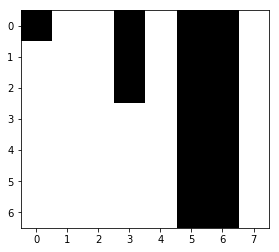

In [39]:
result= result.squeeze(1)
outp = outp.squeeze(1)
G = np.zeros((seq_len,seq_width,3))
for i in range(seq_len):
    for j in range(seq_width):
        if result[i][j]==1:
            G[i][j] = [1,1,1]
        else:
            G[i][j] = [0,0,0]
plt.imshow(G,interpolation='nearest')
plt.show()